# 导入包、定义函数

In [1]:
import numpy as np
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from sklearn.utils import shuffle
from sklearn import metrics
from sites_transformer import Encoder, create_padding_mask
from tools import plot_history

In [2]:
def seq_position_encode(seq):
    amino_acids = '#ARNDCQEGHILKMFPSTWYV'
    seq = re.sub('[XZUB]',"",seq)
    t = np.zeros((len(seq), 21))
    for i in range(len(seq)):
        j = amino_acids.index(seq[i])
        if i%2 == 0:
            t[i][j] = np.exp(np.sin(i))
        if i%2 == 1:
            t[i][j] = np.exp(np.cos(i))
    return np.sum(t, axis=0)
            

In [3]:
def load_seq_data(file):
    data = np.load(file, allow_pickle=True)
    posseqs, negseqs = data['pos'], data['neg']
    x_pos = np.ndarray(shape=(len(posseqs),21))
    i = 0
    for seq in posseqs:
        x_pos[i] = seq_position_encode(seq)
        i += 1
    
    x_neg = np.ndarray(shape=(len(negseqs), 21))
    i = 0
    for seq in negseqs:
        x_neg[i] = seq_position_encode(seq)
        i += 1
        
    return x_pos, x_neg

# 准备数据

In [14]:
# prepare data
x_pos_train, x_neg_train = load_seq_data('PDNA_543_train_15.npz')
x_pos_test, x_neg_test = load_seq_data('PDNA_543_test_15.npz')

x_test = np.concatenate((x_pos_test, x_neg_test))
y_test = [0 for _ in range(x_pos_test.shape[0])] + [1 for _ in range(x_neg_test.shape[0])]
y_test = keras.utils.to_categorical(y_test, num_classes=2)

In [29]:
#x_pos_train = np.tile(x_pos_train, reps=(14,1))
x_train = np.concatenate((x_pos_train, x_neg_train))
y_train = [0 for _ in range(x_pos_train.shape[0])] + [1 for _ in range(x_neg_train.shape[0])]


In [6]:
# over-sampling
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train) 
y_train = keras.utils.to_categorical(y_train, num_classes=2)

Using TensorFlow backend.


In [17]:
# NearMiss under-sampling
from imblearn.under_sampling import NearMiss
us = NearMiss()
x_train_res, y_train_res = us.fit_resample(x_train, y_train) 

In [ ]:
# cluster-under-sampling
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=42)
x_train_       res, y_train_res = cc.fit_resample(x_train, y_train)

In [30]:
from collections import Counter
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_train_res))

Original dataset shape Counter({1: 134995, 0: 9549})


# Training and Testing

In [18]:
def DNN_train(x_train, y_train, x_test, y_test, epochs=20, batch_size=100, x_weight=None):
    inputs = layers.Input(shape=(21, ))
    x = layers.Dense(300, activation='relu')(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1000, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(2, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    # Train
    # method 1: weight balancing
    model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
    
    model.summary()

    if x_weight == None:
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
    else:
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, sample_weight=x_weight,
                            validation_split=0.1)
        
    #plot_history(history)
    
    prediction = model.predict(x_test)
    y_pred = np.argmax(prediction, axis=1)
    
    return y_pred, history

# training and testing

In [25]:
epochs = 50
batch_size = 200

#y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_train_res = keras.utils.to_categorical(y_train_res, num_classes=2)

x_train_res, y_train_res = shuffle(x_train_res, y_train_res)
K.clear_session()
y_pred, history = DNN_train(x_train_res, y_train_res, x_test, y_test, batch_size=batch_size, epochs=epochs)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense (Dense)                (None, 300)               6600      
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              301000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               300300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0     

Epoch 46/50
15278/15278 [==============================] - 2s 124us/sample - loss: 0.3858 - accuracy: 0.8245 - val_loss: 0.6208 - val_accuracy: 0.7293
Epoch 47/50
15278/15278 [==============================] - 2s 123us/sample - loss: 0.3859 - accuracy: 0.8217 - val_loss: 0.6044 - val_accuracy: 0.7267
Epoch 48/50
15278/15278 [==============================] - 2s 121us/sample - loss: 0.3848 - accuracy: 0.8235 - val_loss: 0.6446 - val_accuracy: 0.7183
Epoch 49/50
15278/15278 [==============================] - 2s 120us/sample - loss: 0.3781 - accuracy: 0.8258 - val_loss: 0.6099 - val_accuracy: 0.7202
Epoch 50/50
15278/15278 [==============================] - 2s 122us/sample - loss: 0.3765 - accuracy: 0.8288 - val_loss: 0.6343 - val_accuracy: 0.7188


# Metrics

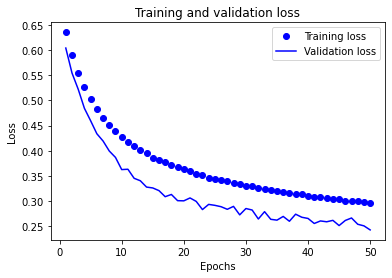

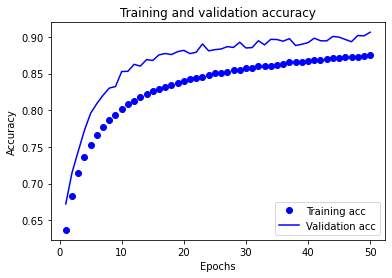

In [9]:
%matplotlib inline
plot_history(history)

In [26]:
# predict performance
y_true = np.argmax(y_test, axis=1)
cm = metrics.confusion_matrix(y_true, y_pred)
acc = metrics.accuracy_score(y_true, y_pred)
mcc = metrics.matthews_corrcoef(y_true, y_pred)
print("cm: ", cm)
print("accuracy: ", acc)
print("MCC: ", mcc)

cm:  [[  581   153]
 [11082  2939]]
accuracy:  0.23856319891562183
MCC:  0.0006235755407892898


In [24]:
np.sum(y_train_res,axis=0)

array([9549., 9549.], dtype=float32)

In [22]:
y_train_res = keras.utils.to_categorical(y_train_res, num_classes=2)
